In [0]:
import tensorflow.keras

In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# This is the path to the image you want to transform.
target_image_path = '/content/target.jpg'
# This is the path to the style image.
style_reference_image_path = '/content/wall.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

W0807 10:08:12.680921 139676891223936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss =+ content_weight * content_loss(target_image_features,combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

W0807 10:09:35.617666 139676891223936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from scipy.optimize import fmin_l_bfgs_b
import imageio
import time

result_prefix = 'style_transfer_result'
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imageio.imwrite(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 840498700.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 567s
Start of iteration 1
Current loss value: 366571200.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 568s
Start of iteration 2
Current loss value: 249169260.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 569s
Start of iteration 3
Current loss value: 196227620.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 570s
Start of iteration 4
Current loss value: 168205950.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 570s
Start of iteration 5
Current loss value: 149945620.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 570s
Start of iteration 6
Current loss value: 137030780.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 570s
Start of iteration 7
Curren

E0807 13:00:18.716184 139676891223936 ultratb.py:152] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-b7f28178fd99>", line 18, in <module>
    fprime=evaluator.grads, maxfun=20)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py", line 199, in fmin_l_bfgs_b
    **opts)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py", line 335, in _minimize_lbfgsb
    f, g = func_and_grad(x)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/lbfgsb.py", line 285, in func_and_grad
    f = fun(x, *args)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py", line 326, in function_wrapper
    return function(*(wrapper_args + args))
  File "<ipython-input-20-9720e3f9c7b4>", line 16, in loss
    outs = fetch_loss_and_grads([x])
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py", line 3

KeyboardInterrupt: ignored

NameError: ignored

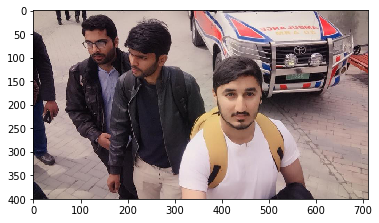

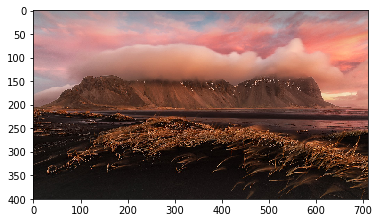

<Figure size 432x288 with 0 Axes>

In [0]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()

In [0]:
import numpy as np
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as k
import cv2

In [0]:
base_image_array = cv2.imread("target.jpg")
base_image_array = cv2.resize(base_image_array, (711, 400))

style_image_array = cv2.imread("wall.jpg")
style_image_array = cv2.resize(style_image_array, (711, 400))


base_image = k.variable(np.expand_dims(base_image_array, axis=0))
style_image = k.variable(np.expand_dims(style_image_array, axis=0))
combination_image = k.placeholder((1, 400, 711, 3))

In [0]:
input_tensor = k.concatenate([base_image, style_image, combination_image], axis=0)

In [0]:
#build the network 
model = vgg16.VGG16(input_tensor=input_tensor, weights="imagenet", include_top=False)

print("Model loaded..!")

58892288/58889256 [==============================] - 1s 0us/step
Model loaded..!


In [0]:
#save keras model
model.save('model.h5')

#get all layers name to know the input tensor-name
for layer in model.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import lite

print( tf.VERSION )

#inception input shape is [1, 299, 299, 3]
converter = lite.TFLiteConverter.from_keras_model_file("model.h5",
                                                       input_shapes={'input_2': [3, 400, 711, 3]}
                                                       )
model = converter.convert()

file = open( 'model.tflite' , 'wb' ) 
file.write( model )

1.14.0


W0807 13:01:50.970952 139676891223936 hdf5_format.py:221] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0807 13:01:51.062488 139676891223936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0807 13:01:51.063881 139676891223936 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


58864252

In [0]:
#check input/output shape
interpreter = lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

print(interpreter.get_input_details()[0]['shape'])  
print(interpreter.get_input_details()[0]['dtype']) 

print(interpreter.get_output_details()[0]['shape'])  
print(interpreter.get_output_details()[0]['dtype']) 

[  3 400 711   3]
<class 'numpy.float32'>
[  3  12  22 512]
<class 'numpy.float32'>
